In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight


import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE



In [2]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'mel',
    5: 'nv',
    6: 'vasc'
}
labels = {
    0: 'Actinic keratoses (akiec)',
    1: 'Basal cell carcinoma (bcc)',
    2: 'Benign keratosis-like lesions (bkl)',
    3: 'Dermatofibroma (df)',
    4: 'Melanoma (mel)',
    5: 'Melanocytic nevi (nv)',
    6: 'Vascular lesions (vasc)',
}
int_label_mapping = dict((value, key) for key, value in label_mapping.items())

SIZE=32  # image size

In [3]:
data = pd.read_csv('data/HAM10000_metadata.csv')

# labele = LabelEncoder()
# labele.fit(data['dx'])
# data['label'] = labele.transform(data["dx"]) 

# print(list(labele.classes_))


In [4]:
data['path'] = './data/HAM10000_images/' + data['image_id'] +".jpg"

In [5]:
data.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./data/HAM10000_images/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./data/HAM10000_images/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./data/HAM10000_images/ISIC_0026769.jpg


In [6]:
hair_images=data['path']

In [7]:
hair_images=list(hair_images)

In [10]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from PIL import Image

[]

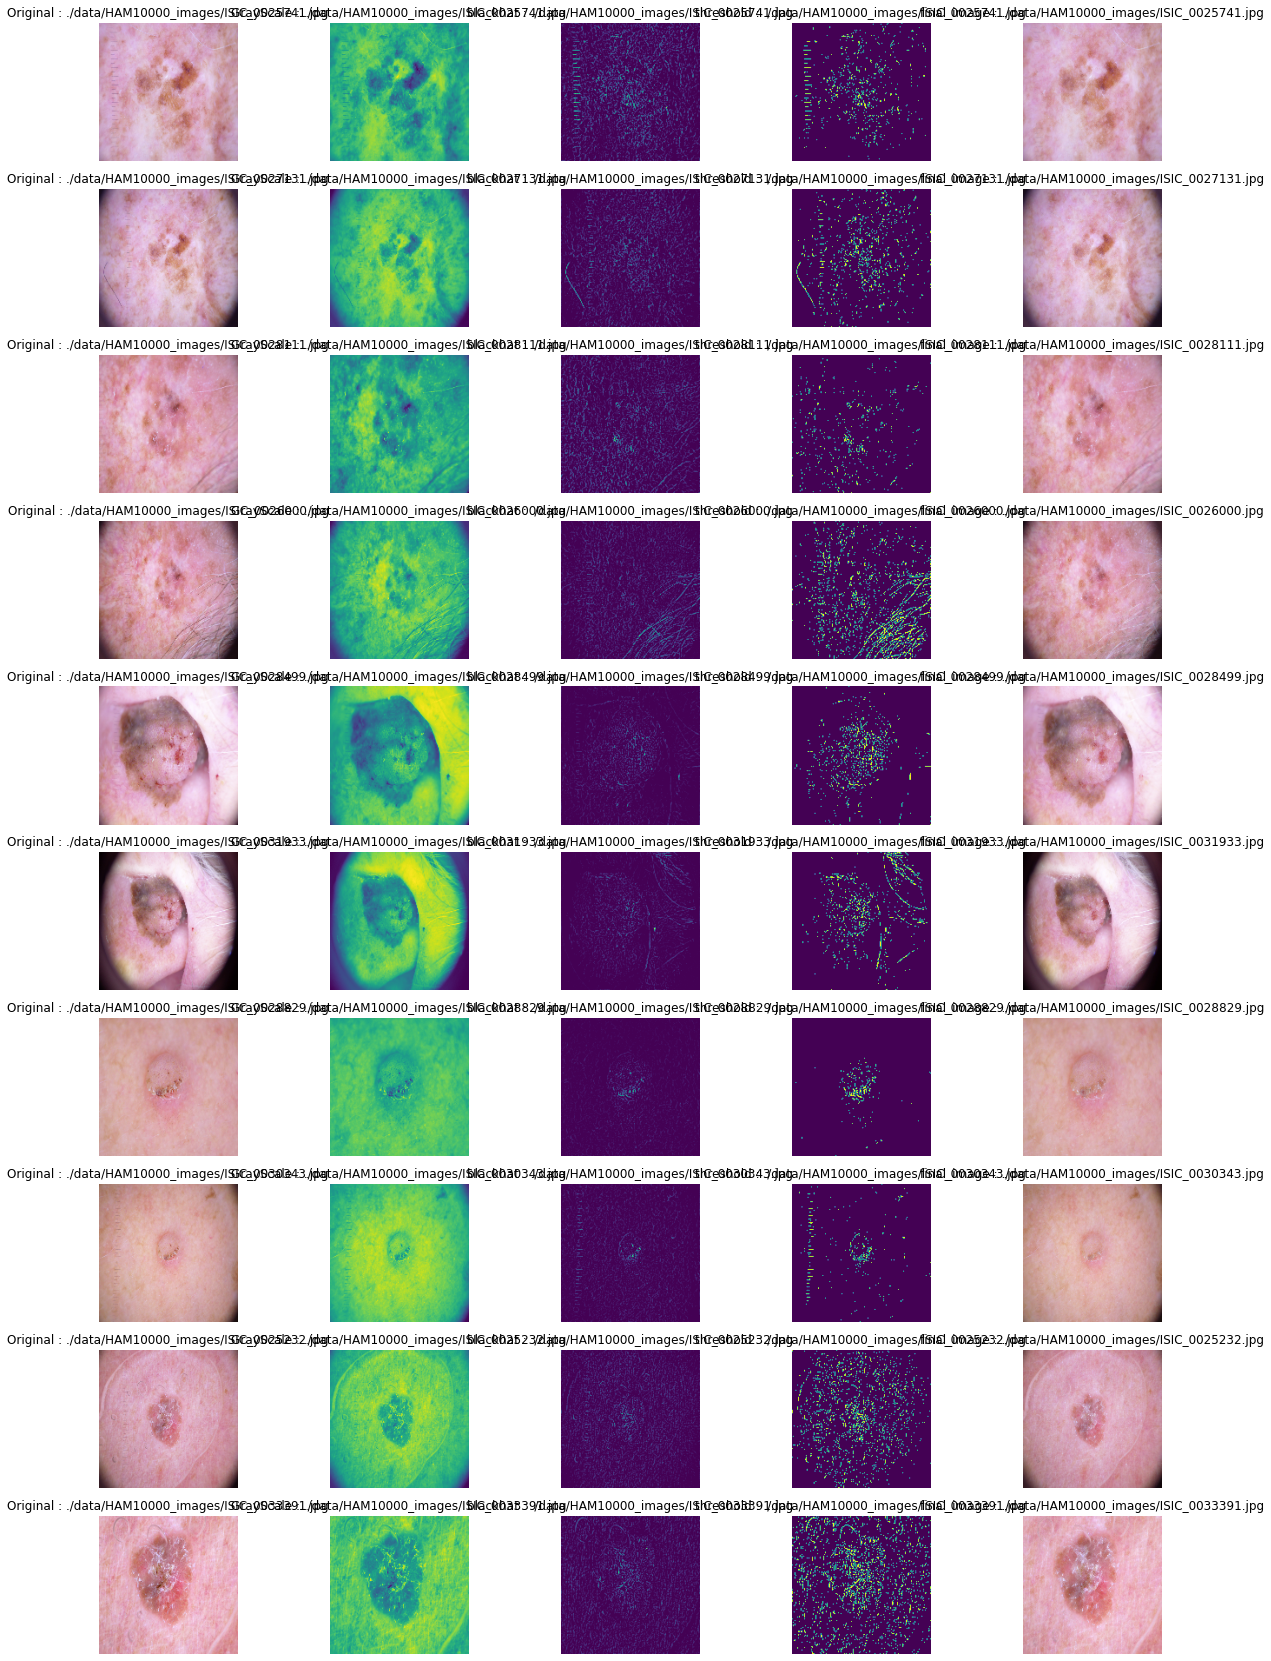

In [11]:
l = len(hair_images[600:610])

fig = plt.figure(figsize=(20,30))

for i,image_name in enumerate(random.sample(hair_images[0:10015],10)):
    
    
    image = cv2.imread(hair_images[i])
    image_resize = cv2.resize(image,(160,160))
    plt.subplot(l, 5, (i*5)+1)
    # Convert the original image to grayscale
    plt.imshow(cv2.cvtColor(image_resize, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original : '+ image_name)
    
    grayScale = cv2.cvtColor(image_resize, cv2.COLOR_RGB2GRAY)
    plt.subplot(l, 5, (i*5)+2)
    plt.imshow(grayScale)
    plt.axis('off')
    plt.title('GrayScale : '+ image_name)
    
    # Kernel for the morphological filtering
    kernel = cv2.getStructuringElement(1,(3,3))
    
    # Perform the blackHat filtering on the grayscale image to find the hair countours
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    plt.subplot(l, 5, (i*5)+3)
    plt.imshow(blackhat)
    plt.axis('off')
    plt.title('blackhat : '+ image_name)
    
    # intensify the hair countours in preparation for the inpainting 
    ret,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    plt.subplot(l, 5, (i*5)+4)
    plt.imshow(threshold)
    plt.axis('off')
    plt.title('threshold : '+ image_name)
    
    # inpaint the original image depending on the mask
    final_image = cv2.inpaint(image_resize,threshold,5,cv2.INPAINT_TELEA)
    plt.subplot(l, 5, (i*5)+5)
    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('final_image : '+ image_name)
       
plt.plot()

In [12]:
def shave_the_mole(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(1,(3,3))
    blackhat = cv2.morphologyEx(grayscale, cv2.MORPH_BLACKHAT, kernel)
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    shaved_mole = cv2.inpaint(image,threshold,5,cv2.INPAINT_TELEA)
    return shaved_mole


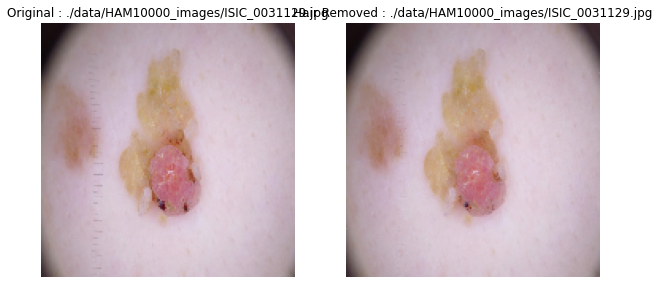

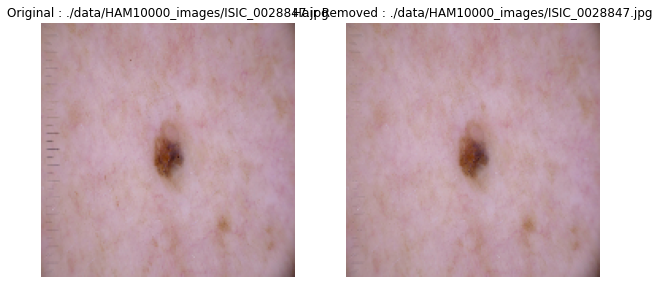

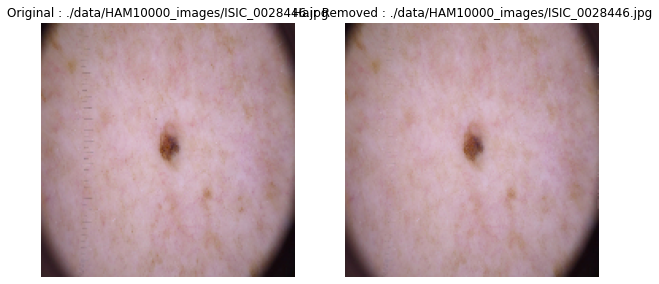

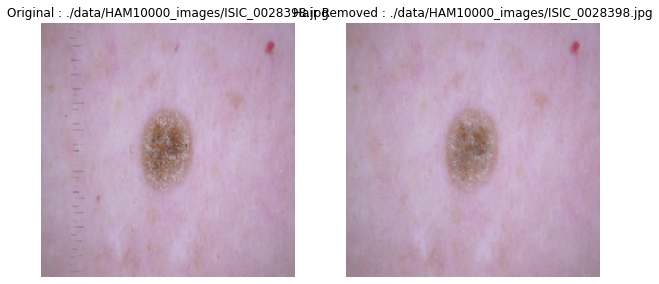

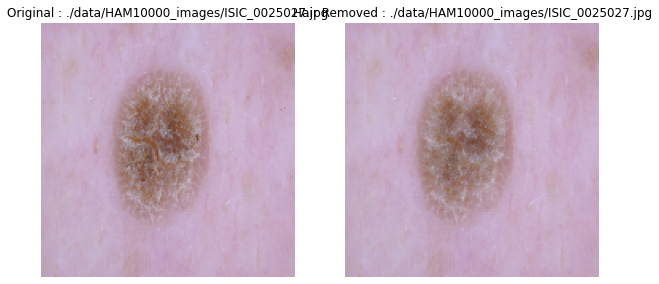

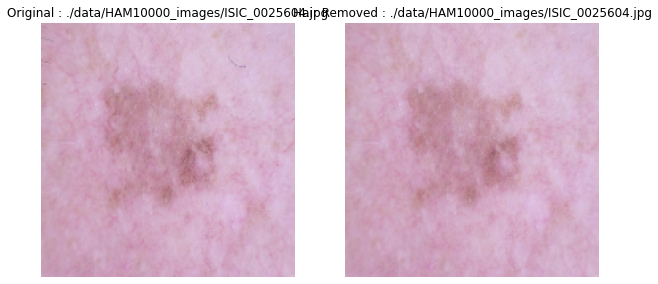

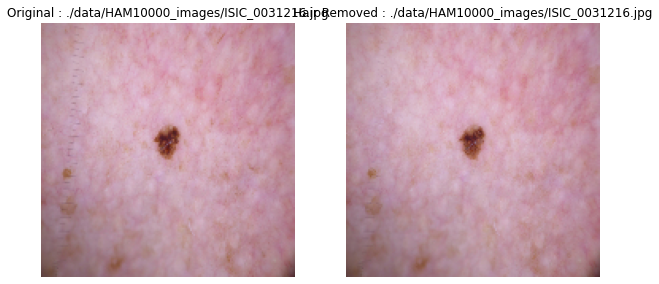

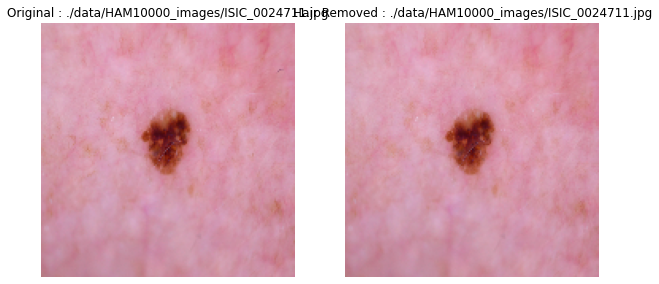

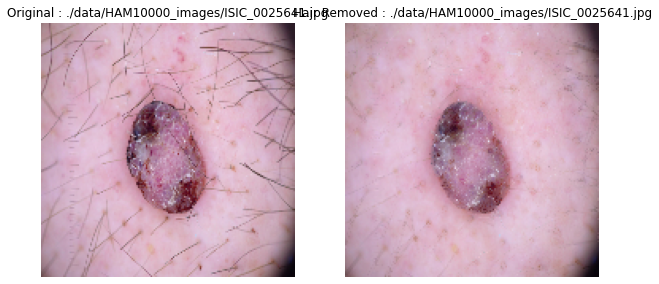

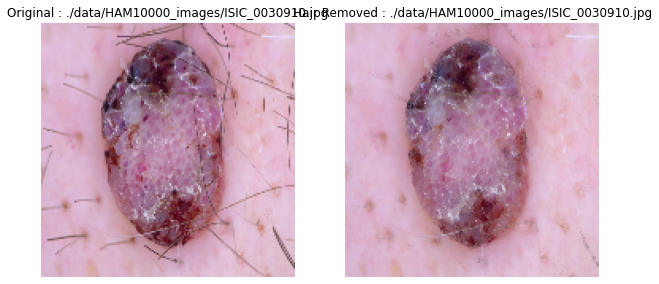

In [15]:
features_list=[]
for i,image_name in enumerate(random.sample(hair_images[0:10015],10)):
    
    fig = plt.figure(figsize=(10,5))
    
    image = cv2.imread(hair_images[i+10])
    image_resize = cv2.resize(image,(160,160))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image_resize, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original : '+ image_name)
    
    final_image = shave_the_mole(image_resize)
    #features_list.append(final_image)
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Hair Removed : '+ image_name)
    
    plt.plot()

In [16]:
features_list=[]
for i,image_name in enumerate(hair_images[0:10015]):
    image = cv2.imread(hair_images[i])
    image_resize = cv2.resize(image,(160,160))
    final_image = hair_remove(image_resize)
    final_image=cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
    features_list.append(final_image)
    
data['image_pp']=features_list   

In [17]:
data.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image_pp
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./data/HAM10000_images/ISIC_0027419.jpg,"[[[187, 152, 193], [192, 157, 197], [192, 157,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./data/HAM10000_images/ISIC_0025030.jpg,"[[[24, 13, 21], [25, 12, 22], [25, 15, 27], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./data/HAM10000_images/ISIC_0026769.jpg,"[[[185, 125, 133], [192, 132, 142], [194, 138,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./data/HAM10000_images/ISIC_0025661.jpg,"[[[23, 11, 15], [25, 10, 20], [24, 11, 20], [3..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./data/HAM10000_images/ISIC_0031633.jpg,"[[[127, 85, 107], [136, 92, 115], [147, 100, 1..."


In [2]:
from pathlib import Path
from collections import Counter
import json
import pandas as pd
import csv
import os

IMAGE_DIR = os.path.join('.', 'data\\images\\')

In [2]:
files=pd.read_csv('checkfile.csv')

In [5]:
files['path']= IMAGE_DIR + files['image_id'] + ".JPG"

In [7]:
files['exist']=0

In [10]:
from os.path import exists

files['exist'] = files['path'].map(lambda x: exists(x))




In [13]:
files.to_csv('exisingfiles.csv')

In [8]:
files

,image_id,nebu2,pix1,pix2,age,localization,bm,dx,nebu1,tf,del,path,exist
0,ISIC_0000000,dermoscopic,1022,767,55.0,anterior torso,benign,nevus,NaN,True,NaN,.\data\images\ISIC_0000000.JPG,0
1,ISIC_0000001,dermoscopic,1022,767,30.0,anterior torso,benign,nevus,NaN,True,NaN,.\data\images\ISIC_0000001.JPG,0
2,ISIC_0000002,dermoscopic,1022,767,60.0,upper extremity,malignant,melanoma,histopathology,True,NaN,.\data\images\ISIC_0000002.JPG,0
3,ISIC_0000003,dermoscopic,1022,767,30.0,upper extremity,benign,nevus,NaN,True,NaN,.\data\images\ISIC_0000003.JPG,0
4,ISIC_0000004,dermoscopic,1022,767,80.0,posterior torso,malignant,melanoma,histopathology,True,NaN,.\data\images\ISIC_0000004.JPG,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60497,ISIC_9995691,dermoscopic,1872,1053,50.0,upper extremity,benign,nevus,serial imaging showing no change,True,NaN,.\data\images\ISIC_9995691.JPG,0
60498,ISIC_9997614,NaN,3264,2448,50.0,upper extremity,benign,nevus,histopathology,True,NaN,.\data\images\ISIC_9997614.JPG,0
60499,ISIC_9998682,NaN,4032,3024,60.0,head/neck,malignant,melanoma,histopathology,True,NaN,.\data\images\ISIC_9998682.JPG,0
60500,ISIC_9998937,dermoscopic,1872,1053,40.0,head/neck,benign,nevus,serial imaging showing no change,True,NaN,.\data\images\ISIC_9998937.JPG,0


In [4]:


dir = Path('Descriptions')
#out_file = Path('output.txt')

#data=pd.read_csv('imagemain.csv')


import json




for file in dir.glob('*'):
    with file.open('r', encoding='utf-8') as f:
        _f = json.load(f)
        
        _h = []
        
        # _h.append(_f["id"])
        try:
            _h.append(_f["name"])
        except:
            _h.append('')

        try:
            _h.append(_f["meta"]["acquisition"]["image_type"])
        except:
            _h.append('')

        try:
            _h.append(_f["meta"]["acquisition"]["pixelsX"])
        except:
            _h.append('')

        try:
            _h.append(_f["meta"]["acquisition"]["pixelsY"])
        except:
            _h.append('')

        try:
            _h.append(_f["meta"]["clinical"]["age_approx"])
        except:
            _h.append('')
            
        try:
            _h.append(_f["meta"]["clinical"]["anatom_site_general"])
        except:
            _h.append('')

        try:
            _h.append(_f["meta"]["clinical"]["benign_malignant"])
        except:
            _h.append('')
        
        try:
            _h.append(_f["meta"]["clinical"]["diagnosis"])
        except:
            _h.append('')

        try:
            _h.append(_f["meta"]["clinical"]["diagnosis_confirm_type"])
        except:
            _h.append('')
            
        try:
            _h.append(_f["meta"]["clinical"]["melanocytic"])
        except:
            _h.append('')
        
        with open('_prop4.csv', 'a', newline='') as f:
                    write = csv.writer(f)
                    write.writerow(_h)
        
        
     

        



In [6]:
data

,lesion_id,image_id,dx,dx_type,age,sex,localization


In [14]:
from PIL import Image
import os, sys

path = "./data/images/"
dirs = os.listdir( path )

files=pd.read_csv('data/HAM10000_metadata.csv')



def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((640,480))
            imResize.save(f + ' r.jpg', 'JPEG', quality=90)



In [19]:
files

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [45]:
files['dx'].value_counts(dropna=False)

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [27]:
a=dict(files['dx'].value_counts())

In [30]:
files

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [32]:
IMAGE_DIR = os.path.join('.', 'data\\HAM10000_images\\')
files['path']= IMAGE_DIR + files['image_id'] + ".JPG"

In [37]:
files['destination'] = IMAGE_DIR+ files['dx'] + "\\" + files['image_id'] + ".JPG"

In [38]:
files

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,destination
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.\data\HAM10000_images\ISIC_0027419.JPG,.\data\HAM10000_images\bkl\ISIC_0027419.JPG
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,.\data\HAM10000_images\ISIC_0025030.JPG,.\data\HAM10000_images\bkl\ISIC_0025030.JPG
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,.\data\HAM10000_images\ISIC_0026769.JPG,.\data\HAM10000_images\bkl\ISIC_0026769.JPG
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,.\data\HAM10000_images\ISIC_0025661.JPG,.\data\HAM10000_images\bkl\ISIC_0025661.JPG
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,.\data\HAM10000_images\ISIC_0031633.JPG,.\data\HAM10000_images\bkl\ISIC_0031633.JPG
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,.\data\HAM10000_images\ISIC_0033084.JPG,.\data\HAM10000_images\akiec\ISIC_0033084.JPG
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,.\data\HAM10000_images\ISIC_0033550.JPG,.\data\HAM10000_images\akiec\ISIC_0033550.JPG
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,.\data\HAM10000_images\ISIC_0033536.JPG,.\data\HAM10000_images\akiec\ISIC_0033536.JPG
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,.\data\HAM10000_images\ISIC_0032854.JPG,.\data\HAM10000_images\akiec\ISIC_0032854.JPG


In [46]:
import shutil
for a in files.values:
    #print(a[7])
    shutil.move(a[7], a[8])

In [6]:
from os.path import exists

#file_exists = exists(path_to_file)


In [7]:
files['exists']=files['path'].map(lambda x: exists(x))

In [47]:
files.to_csv("_prop2.csv")

In [ ]:
import splitfolders

In [50]:
files

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,destination
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,.\data\HAM10000_images\ISIC_0027419.JPG,.\data\HAM10000_images\bkl\ISIC_0027419.JPG
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,.\data\HAM10000_images\ISIC_0025030.JPG,.\data\HAM10000_images\bkl\ISIC_0025030.JPG
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,.\data\HAM10000_images\ISIC_0026769.JPG,.\data\HAM10000_images\bkl\ISIC_0026769.JPG
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,.\data\HAM10000_images\ISIC_0025661.JPG,.\data\HAM10000_images\bkl\ISIC_0025661.JPG
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,.\data\HAM10000_images\ISIC_0031633.JPG,.\data\HAM10000_images\bkl\ISIC_0031633.JPG
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,.\data\HAM10000_images\ISIC_0033084.JPG,.\data\HAM10000_images\akiec\ISIC_0033084.JPG
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,.\data\HAM10000_images\ISIC_0033550.JPG,.\data\HAM10000_images\akiec\ISIC_0033550.JPG
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,.\data\HAM10000_images\ISIC_0033536.JPG,.\data\HAM10000_images\akiec\ISIC_0033536.JPG
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,.\data\HAM10000_images\ISIC_0032854.JPG,.\data\HAM10000_images\akiec\ISIC_0032854.JPG


In [49]:

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array



In [61]:


datagen= ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')


In [68]:
IMAGE_DIR = os.path.join('.', 'data\\HAM10000_images\\vasc\\')
count = 0
for batch in datagen.flow_from_directory(directory=IMAGE_DIR,  class_mode=None, batch_size=40,save_to_dir=IMAGE_DIR, save_prefix='g', save_format='jpg'):
    count += 1
    if count > 164:
        break


Found 142 images belonging to 2 classes.


In [69]:
import splitfolders
IMAGE_DIR = os.path.join('.', 'data\\HAM10000_images\\')
splitfolders.ratio(IMAGE_DIR,'IMAGES',seed=42, ratio=(0.7,0.2,0.1))